# Mouse Signals
## TODO:
 1. check the error: "timebetween2bits"
 2. implement the maxlength of a packet: if somethin went wrong, goes to 'endcom' also if it has not collected all bits!

In [419]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import re as re
%matplotlib inline

mpl.rcParams['axes.titlesize']=30
mpl.rcParams['legend.fontsize']=20
mpl.rcParams['text.usetex']=True
mpl.rcParams['axes.grid']=True
path='./Resources/Aquisition/'

In [2]:
# import del secondo set di dati
t1=pd.read_csv(path+'scope_1_1.csv',usecols=[0,1],names=["time","ch1"],dtype=np.float64,skiprows=2)
t2=pd.read_csv(path+'scope_1_2.csv',usecols=[0,1],names=["time","ch2"],dtype=np.float64,skiprows=2)
tt=pd.DataFrame({'time':t1['time'],'ch1':t1['ch1'],'ch2':t2['ch2']})
dati2=tt.set_index('time')


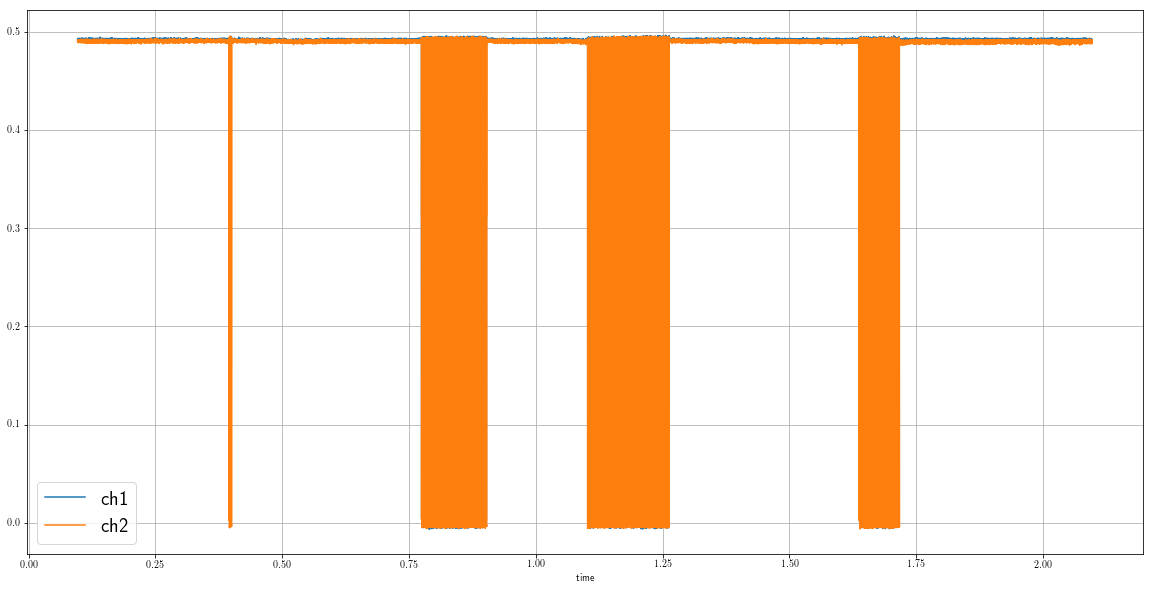

In [3]:
dati2.plot(figsize=(20,10))


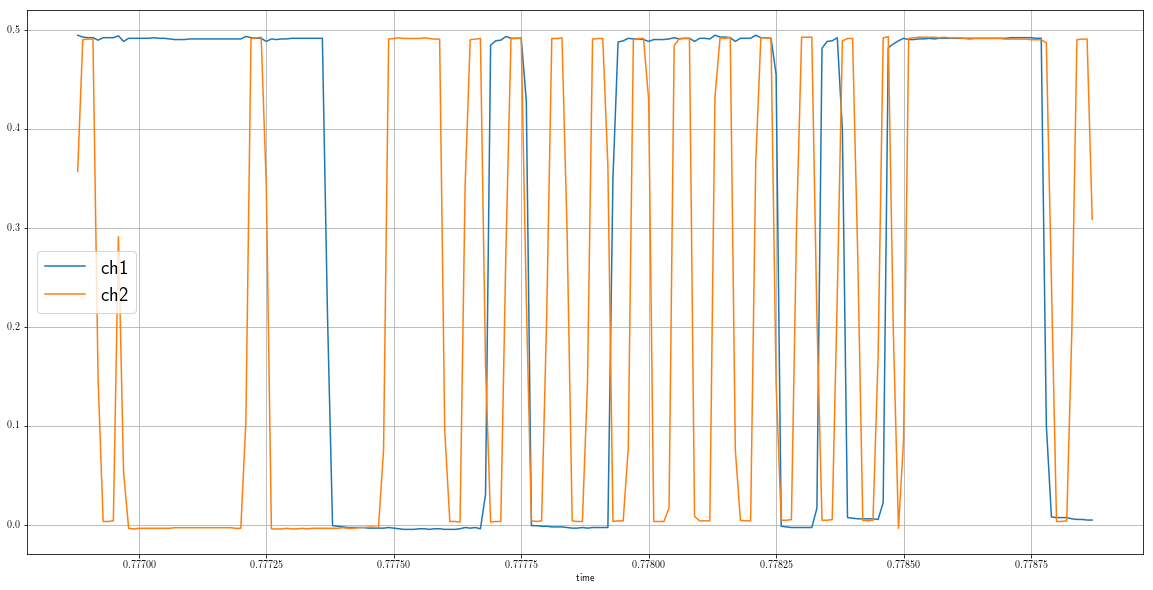

In [360]:
#finestra=[0.77,0.9]
#finestra=[0.78,0.782]

#dati2.iloc[(dati2.index>finestra[0])*(dati2.index<finestra[1])].plot(figsize=(20,10))


clock    1
data     1
Name: 0.37687993256, dtype: int64

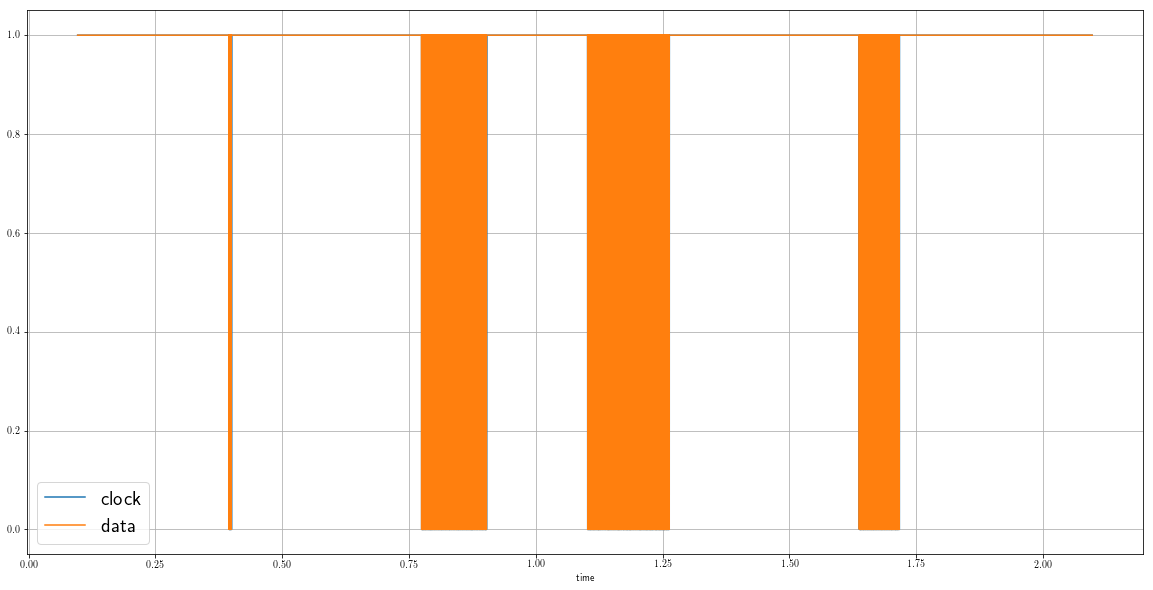

In [101]:
sogliaTTL=0.7*(5/10)
data=dati2['ch1'].values
clock=dati2['ch2'].values

data=data>sogliaTTL
clock=clock>sogliaTTL
dati2Digital=pd.DataFrame({'data':data, 'clock':clock},index=dati2.index,dtype=np.int64)


dati2Digital.plot(figsize=(20,10)) # contains digitalized data, array of bool
dati2Digital.iloc[28000]

In [10]:
muS=10**-6
Tsampling=10*muS
Tclk=80*muS
Tclkduty=Tclk/2
TclkHb4CtTx=50*muS
TminCD=5*muS
TminDC=5*muS
TmaxDC=25*muS
TClkL4inh=100*muS
Tmax4CtGenClkPulses=15*10**3*muS
Tmax4PcktSending=2*10**3*muS
TmaxCtResponse=20*10**3*muS

# the names below can be obtained as:
# cat <the_precedent_as_a_file> | gawk -v FS="=" '{print $1;}' | sed s/^T/t/
# the final is
# parallel echo {1}={2}/{3} ::::+ <result of precedent> ::::+  <(cat poi | gawk -v FS="=" '{print $1;}') ::: Tsampling

tsampling=Tsampling/Tsampling
tclk=Tclk/Tsampling
tclkduty=Tclkduty/Tsampling
tclkHb4CtTx=TclkHb4CtTx/Tsampling
tminCD=np.ceil(TminCD/Tsampling)
tminDC=np.ceil(TminDC/Tsampling)
tmaxDC=np.ceil(TmaxDC/Tsampling)
tClkL4inh=TClkL4inh/Tsampling
tmax4CtGenClkPulses=Tmax4CtGenClkPulses/Tsampling
tmax4PcktSending=Tmax4PcktSending/Tsampling
tmaxCtResponse=TmaxCtResponse/Tsampling

(tsampling ,tclk ,tclkduty ,tclkHb4CtTx ,tminCD ,tminDC ,tmaxDC ,tClkL4inh ,tmax4CtGenClkPulses ,tmax4PcktSending ,tmaxCtResponse)

(1.0,
 8.0,
 4.0,
 5.0,
 1.0,
 1.0,
 3.0,
 10.0,
 1500.0,
 200.00000000000003,
 2000.0000000000002)

In [391]:
class readSig():
    def __init__(self,clock,data,start=0):
        self.t=counter(len(clock),count=start)
        
        self.C=True
        self.D=True
        self.Co=True
        self.Do=True
        self.CDo=(self.Co,self.Do) # start in pause state
        self.CD=(self.C,self.D)
        
        self.buf=[]
        self.clock=clock
        self.data=data
        self.status='idle'
        self.counters={}
        self.packets=[]
        
        self.counters['endPacket']=counter(6,en=False) # the time for this counter is up to me
        self.counters['endCom']=counter(2,en=False)     # the time for this counter is up to me
        self.counters['tClkL4inh']=counter(tClkL4inh,en=False)
        self.counters['maxTbetweenClock']=counter(20,en=False)
         
    def tick(s):
        ##tmp for solve problem!
        if (len(s.packets)==55):
            pass
            #print(s.t.count)
        ##
        
        ## INITIALIZATION
        # first upload t, C_lock-D_ata-s_tatus, and all counters
        s.t.inc()
        
        s.C=s.clock[s.t.count]
        s.D=s.data[s.t.count]
        s.CD=(s.C,s.D)
        
        # increments all counters
        for k in s.counters:
            s.counters[k].inc()
        
        ## IDLE ##
        # basic status. wait for either a device transmission or host request
        # to transmit.
        if (s.status=='idle'):
            if (s.CD==HH):
                pass
            elif (s.CD==HL):
                s.status='dhc'
                s.counters['tminDC']=counter(tminDC)
                s.counters['tmaxDC']=counter(tmaxDC)
                s.counters['maxTbetweenClock'].enable()
            elif (s.CD==LH):
                s.status='waitDevClock'
                s.counters['tClkL4inh'].enable()
            else:
                raise ValueError('clock and data changed simultaneously!')
                
        ## DHC ##
        # device to host. 
        elif (s.status=='dhc'):
            #if s.counters['tmaxDC']:
            #    raise CounterError('too much time from data low and clock')
            if s.counters['maxTbetweenClock']:
                raise CounterError('too much time between 2 bits, something went wrong?')
                
            if (len(s.buf)<11):
                if (s.Co and not s.C):
                    s.buf.append(s.D)
                    #s.counters['tmaxDC'].hreset()    
                    s.counters['maxTbetweenClock'].reset()
                if (s.Co and s.C):
                    pass
                if (not s.Co and not s.C):
                    pass
                if (not s.Co and s.C):
                    pass
            else:
                s.status='endCom'
                #s.counters['endCom'].enable()
                s.counters['endPacket'].enable()
                s.counters['maxTbetweenClock'].hreset()
                
        ## ENDCOM ##
        elif (s.status=='endCom'):
            if (s.counters['endPacket']):
                s.counters['endCom'].enable()
                if (s.counters['endCom'] and s.C and s.D):
                    s.status='idle'
                    s.packets.append(s.buf)
                    s.buf=[]
                    s.counters['endCom'].hreset()
                    s.counters['endPacket'].hreset()
                if not(s.C and s.D):
                    s.counters['endCom'].reset()
                else:
                    pass
            else:
                pass
            
            # previous version, uses only endcom and not endpacket
            '''# Wait for clock and data to be both high for a defined amount
            # of time which is 10ticks. then flush the buf, hreset the counter
            # and put in idle state, ready to receive other packets.
            elif (s.status=='endCom'):
                if (s.counters['endCom'] and s.C and s.D):
                    s.status='idle'
                    s.packets.append(s.buf)
                    s.buf=[]
                    s.counters['endCom'].hreset()
                if not(s.C and s.D):
                    s.counters['endCom'].reset()
                else:
                    pass'''
            # old version if the precedent should hav problems
            # simply i count 10 ticks but suddenly, that is i
            # don't wait for clock and data to be and remain high
            '''if (s.counters['endCom'] and s.C and s.D):
                s.status='idle'
                s.packets.append(s.buf)
                s.buf=[]
                s.counters['endCom'].hreset()'''
        ## WAITDEVCLOCK ##
        # wait for 100uS and make sure the clock remain low. If not raise error
        # if all goes well switch to 'hdc' status
        elif (s.status=='waitDevClock'):
            if (s.counters['tClkL4inh'] and not s.C):
                s.counters['tClkL4inh'].hreset()
                s.status='hdc'
            elif (s.C):
                raise ValueError('Clock non tenuto basso per 100uS')
            else:
                pass
            
        ## HDC ##
        # Read the first 11 bits on clock rising edge, and the ack on falling
        # edge, then switch to 'endCom' status. The 'Ack' bit is read on falling edge,
        # so data should change between the rising edge of the 11th bit and the falling
        # edge of the 12th aka 'Ack' bit. Instead it happens that data change is in 
        # advance and the stop_bit is read too late. For this reason the 11th aka stop_bit
        # is read using old data.
        elif (s.status=='hdc'):
            if s.counters['maxTbetweenClock']:
                raise CounterError('too much time between 2 bits, something went wrong?')
            if (len(s.buf)<11):
                if (not s.Co and s.C): #fronte di salita
                    s.buf.append(s.Do if (len(s.buf)==10) else s.D ) # explained above
                    s.counters['maxTbetweenClock'].reset()
                    s.counters['maxTbetweenClock'].enable()
                else:
                    pass # then i would implement counters activation here
            else: # it remains to read the ack
                if (s.Co and not s.C):
                    s.buf.append(s.D) 
                    s.status='endCom'
                    #s.counters['endCom'].enable()
                    s.counters['endPacket'].enable()
                    s.counters['maxTbetweenClock'].hreset()
                else:
                    pass
            #return
        else:
            raise ValueError('status is not defined: %s \n I shouldn\'t be here!'%(s.status))
            #return
        
        ## GENERATE OLD ##
        s.Co=s.C    
        s.Do=s.D
        s.CDo=s.CD
        
        ## FINE TICK ##
        

In [397]:
# 29840
# 30069  # first H2D
# dopo 80492 c'è il problematico
# 68077 timeBetween2bits

startFin = 69512
rang     = 150
finestra=[startFin,startFin+rang]
#finestra=[68000,68000]

R=readSig(clock,data,start=0)
for i in range(199999): #80700
    try:
        R.tick()
    except Exception as e:
        print (e, ' at: %d',R.t.count)
        pass
    
    if (i>finestra[0] and i<finestra[1]):
        pass
        print('i=%3d, count=%d, status= %12s, C=%d, D=%d, buf=%25s, lbuf=%d, pck=%d'%(i,R.t.count,R.status,R.C,R.D,np.array(R.buf,dtype=np.int64),len(R.buf),len(R.packets)))
    if (R.t.count == 199999):
        break
    if (len(R.packets)==17):
        pass
        #print(R.t.count) 
    
    #if (R.status != 'idle'):
    #    print (R.t.count)
    #   break
    
len(R.packets)


i=69513, count=69514, status=         idle, C=1, D=1, buf=                       [], lbuf=0, pck=17
i=69514, count=69515, status= waitDevClock, C=0, D=1, buf=                       [], lbuf=0, pck=17
i=69515, count=69516, status= waitDevClock, C=0, D=1, buf=                       [], lbuf=0, pck=17
i=69516, count=69517, status= waitDevClock, C=0, D=1, buf=                       [], lbuf=0, pck=17
i=69517, count=69518, status= waitDevClock, C=0, D=1, buf=                       [], lbuf=0, pck=17
i=69518, count=69519, status= waitDevClock, C=0, D=1, buf=                       [], lbuf=0, pck=17
i=69519, count=69520, status= waitDevClock, C=0, D=1, buf=                       [], lbuf=0, pck=17
i=69520, count=69521, status= waitDevClock, C=0, D=1, buf=                       [], lbuf=0, pck=17
i=69521, count=69522, status= waitDevClock, C=0, D=1, buf=                       [], lbuf=0, pck=17
i=69522, count=69523, status= waitDevClock, C=0, D=1, buf=                       [], lbuf=0, pck=17


280

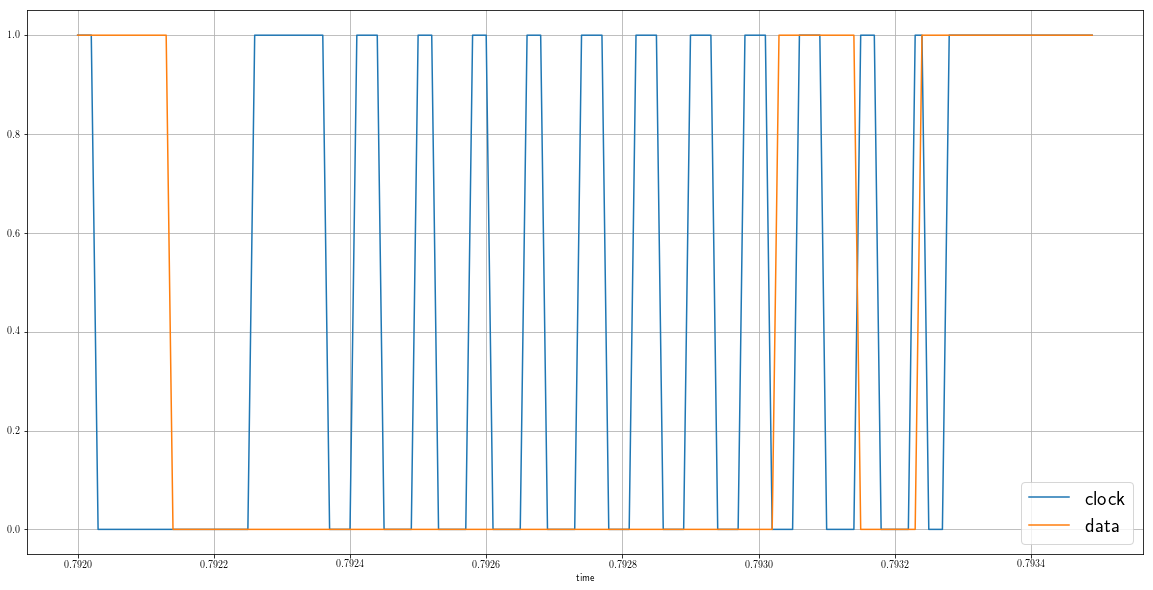

In [388]:
dati2Digital.iloc[list(range(finestra[0],finestra[1]))].plot(figsize=(20,10))
#dati2.iloc[list(range(finestra[0],finestra[1]))].plot(figsize=(20,10))

In [462]:
P=[]
Pp=[]
for i,p in enumerate(R.packets):
    try:
        P.append(packet(p,dizD2H=dizD2H,dizH2D=dizH2D).extractInfo())
    except Exception as e:
        print(e, 'at:%d',i)
        Pp.append(i)


len(P)


280

In [463]:
for p in P:
    pass
    print(p)
    
#a.reverse()
#a

D2H hex:0xaa 	mean:                     	BYTE: 0b10101010
D2H hex:0x00 	mean:                     	BYTE: 0b00000000
H2D hex:0xff 	mean:                     	BYTE: 0b11111111
D2H hex:0xfa 	mean:                  Ack	BYTE: 0b11111010
D2H hex:0xaa 	mean:                     	BYTE: 0b10101010
D2H hex:0x00 	mean:                     	BYTE: 0b00000000
H2D hex:0xf2 	mean:        Get Device ID	BYTE: 0b11110010
D2H hex:0xfa 	mean:                  Ack	BYTE: 0b11111010
D2H hex:0x00 	mean:                     	BYTE: 0b00000000
H2D hex:0xf6 	mean:         Set Defaults	BYTE: 0b11110110
D2H hex:0xfa 	mean:                  Ack	BYTE: 0b11111010
H2D hex:0xf3 	mean:      Set Sample Rate	BYTE: 0b11110011
D2H hex:0xfa 	mean:                  Ack	BYTE: 0b11111010
H2D hex:0x0a 	mean:                     	BYTE: 0b00001010
D2H hex:0xfa 	mean:                  Ack	BYTE: 0b11111010
H2D hex:0xe8 	mean:                     	BYTE: 0b11101000
D2H hex:0xfa 	mean:                  Ack	BYTE: 0b11111010
H2D hex:0x00 	

In [457]:
class packet():
    def __init__(self,byte,direction='',mean='',dizD2H={},dizH2D={}):
        self.byte=byte
        self.direction=direction # H2D or D2H
        self.mean=mean
        self.dizD2H=dizD2H
        self.dizH2D=dizH2D
        self.hex=''
        self.bin=''
        
    def __str__(self):        
        string=self.direction
        string=string+' hex:%4s '%(self.hex)+'\tmean: %20s'%(self.mean)+'\tBYTE: '+self.bin
        return string
    
    def __repr__(self):
        return packet.__str__(self)
    
    def extractInfo(s):
        if (len(s.byte)==11):
            s.direction='D2H'
            s.byte=s.extract(s.byte)
            # here dict
            
        elif (len(s.byte)==12):
            s.direction='H2D'
            if (s.byte[-1]):
                raise ValueError('in H2D ack bit is wrong')
            else:
                s.byte=s.extract(s.byte[0:-1])
            # here dict
        elif (len(s.byte)==8):
            pass
        else:
            raise ValueError('lenght of a packet is wrong!')
        
        # write bin and hex
        s.binAndHex()
        
        # write the meaning
        s.meaning()
        
        return s
        
    def extract(s,byte):
        if (byte[0] or  not byte[-1]):
            raise ValueError('start or stop bits wrong!\nbyte:%s'%(byte))
        else:
            byte=byte[1:-1]
        
        if (not sum(byte)):
            raise ValueError('parità sbagliata')
        else:
            byte=byte[0:-1]
            
        byte.reverse()
        return byte
    
    def binAndHex(s):
        s.bin='0b'
        for b in np.array(s.byte,dtype=np.int64):
            s.bin+=str(b)
        
        # the RE simply put an extra 0 on the hex string, otherwise the
        # first one is omitted.
        s.hex=re.sub(r'(?<=0x)([0123456789abcdef]$)',r'0\1',hex(int(s.bin,2)))
        return s
    def meaning(s):
        try:
            if(s.direction=='D2H'):
                s.mean=dizD2H[s.hex]
            elif(s.direction=='H2D'):
                s.mean=dizH2D[s.hex]
            else:
                raise ValueError('direction must be either D2H or H2D, not:%s'%(s.direction))
        except KeyError as e:
            s.mean=''
        finally:
            return s
        
HH=(True,True)
HL=(True,False)
LH=(False,True)
LL=(False,False)
H=True
L=False

class CounterError(Exception):
    def __init__(self,msg):
        super().__init__(msg)

class counter():
    def __init__(self,limit,count=0,en=True):
        self.limit=int(limit)
        self.finish=False
        self.count=count
        self.en=en
    def inc(self):
        if (self.en and not self.finish):
            self.count=self.count+1
        if (self.count==self.limit):
            self.finish=True
        return self
    def reset(self):
        self.count=0
        self.finish=False
        return self
    def hreset(self):
        self.en=False
        self.reset()
        return self
    def enable(self):
        self.en=True
    def disable(self):
        self.en=False
    def __bool__(self):
        return (self.finish and self.en)

In [461]:
# utile per fare il dizionario: 
# cat commands | gawk  -v FS="\tNone\t" '{print tolower($1)":"$2}' | sed -E 's/([[:alnum:][:blank:]]+)/\x27\1\x27/g'

dizD2H={
    '0xfa':'Ack',
}

dizH2D={
    '0xf6':'Set Defaults',
    '0xf5':'Disable Data Reporting',
    '0xf4':'Enable Data Reporting',
    '0xf3':'Set Sample Rate',
    '0xf2':'Get Device ID',
    '0xf0':'Set Remote Mode',
    '0xee':'Set Wrap Mode',
    '0xec':'Reset Wrap Mode',
    '0xeb':'Read Data',
    '0xea':'Set Stream Mode',
    '0xe9':'Status Request',
}


In [442]:
try:
    assert True
except Exception as k:
    pass
else:
    print('else')
finally:
    print('comunque')

else
comunque


In [411]:
for i,p in enumerate(R.packets):
    if len(p)==12:
        pass
        print(p, ' at:%d',i)

[False, True, True, True, True, True, True, True, True, True, True, False]  at:%d 2
[False, False, True, False, False, True, True, True, True, False, True, False]  at:%d 6
[False, False, True, True, False, True, True, True, True, True, True, False]  at:%d 9
[False, True, True, False, False, True, True, True, True, True, True, False]  at:%d 11
[False, False, True, False, True, False, False, False, False, True, True, False]  at:%d 13
[False, False, False, False, True, False, True, True, True, True, True, False]  at:%d 15
[False, False, False, False, False, False, False, False, False, True, True, False]  at:%d 17
[False, True, True, False, False, True, True, True, True, True, True, False]  at:%d 19
[False, False, False, True, False, True, False, False, False, True, True, False]  at:%d 21
[False, True, True, False, False, True, True, True, True, True, True, False]  at:%d 23
[False, False, False, True, True, True, True, False, False, True, True, False]  at:%d 25
[False, True, True, False, F

In [439]:
a='asd:{uno} but i have also {due}'
b={'uno':'un','due':'doi'}

#a.format(b)
#b.uno
b['trei']


KeyError: 'trei'

In [279]:
a=[0,1,0,0,1]
str(a)
s=''
for b in a:
    s+=str(b)
s    

'01001'

In [108]:
A=counter(3)
A.inc().inc().count
A.hreset()
A.reset()

a=[]
b=[1,2,3]
a.append(b)
a.append(b)
a

print('%s'%(a))

[[1, 2, 3], [1, 2, 3]]


In [30]:
A={}
A['t1']=counter(2)
A['t2']=counter(5)


for i in range (6):
    print('i is:', i)
    for k in A:
        print(k, ' = ', bool(A[k]))
        A[k].inc()



i is: 0
t1  =  False
t2  =  False
i is: 1
t1  =  False
t2  =  False
i is: 2
t1  =  True
t2  =  False
i is: 3
t1  =  True
t2  =  False
i is: 4
t1  =  True
t2  =  False
i is: 5
t1  =  True
t2  =  True


In [45]:
global tmp

try:
    raise CounterError('fdsfsdfsdf')
except CounterError as e:
    print(e)
    tmp=e
    
tmp

fdsfsdfsdf


__main__.CounterError('fdsfsdfsdf')

In [48]:
True and not False

True

In [265]:
A=counter(34)
print(type(A))
A

A.limit
A

NameError: name 'limit' is not defined

In [218]:
class dict2(dict):
    def __getattr__(self, name):
        return self[name]
    def __setattr__(self, name, value):
        super().__setattr__(name, value)

A=dict2()

class dsa():
    def __init__(self,p,q):
        self.p=p
        self.q=q

In [226]:
dsaO=dsa(3,4)
dsaO.r=5
dsaO.r

5